# Exploring the use of Animal Faces dataset

### Importing basic packages
<code style="color:darkblue">
- numpy: computiong library for large/multidimensioanl array and functions
- pandas: data analysis and data manipulation</code>

In [1]:
import numpy as np #numpy library, used for working with arrays
import pandas as pd #pandas library, used for data manipulation & analysis

<code style="color:darkblue">**For AI modeling there are two main libraries:**
    - Tensoflow -> Google brain
    - Pytorch -> Meta AI
**Here, I am also adding all the necessary libraries for this project.**
</code>

In [2]:
import tensorflow as tf #tensorflow library, used for machine learning & neural networks
import torch as pt #PyTorch library, another library used for machine learning
import os #os library, provides functions for interacting with the operating system
import matplotlib.pyplot as plt #matplotlib library, used for creating static, animated, & interactive visualizations
import seaborn as sns #seaborn library, Python data visualization library based on matplotlib
from tensorflow import keras #allows easy and fast prototyping and supports both convolutional networks and recurrent networks

2024-04-09 21:10:16.704425: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 21:10:16.704547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 21:10:16.816576: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<code style="color:darkblue">**Checking tensorflow & torch versions**</code>

In [3]:
print("Tensorflow version: " + tf.__version__) #print Tensorflow version
print("PyTorch version: " + pt.__version__) #print PyTorch version

Tensorflow version: 2.15.0
PyTorch version: 2.1.2


***
# Importing a dataset from Kaggle

<code style="color:darkblue">In every train dataset cat & dog we have around 821 pictures that are called flickr_cat or flickr_dog and around 4834 pixabay_cat or pixabay_dog. Overall in the dataset I have around 5655 images for cat & around 5655 images for dog. Every image has 512×512 resolution. </code>

In [4]:
from PIL import Image #importing the Image module from PIL, which provides image processing capabilities
from tensorflow.keras import datasets, layers, models #used for building & training
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img #used for real-time data augmentation & loading images

In [5]:
src_dirs = ['/kaggle/input/animal-faces/afhq/train/cat', #source directory for cat images in training dataset
            '/kaggle/input/animal-faces/afhq/train/dog', #source directory for dog images in training dataset
            '/kaggle/input/animal-faces/afhq/val/cat', #source directory for cat images in validation dataset
            '/kaggle/input/animal-faces/afhq/val/dog'] #source directory for dog images in validation dataset
dst_dir = '/kaggle/working/' #destination directory for processed data

In [6]:
os.makedirs(dst_dir, exist_ok=True) #to create destination directory if it doesn't exist already

In [7]:
dir_path = '/kaggle/working/' #define directory path
items = os.listdir(dir_path) #list all items in the directory
for item in items: #iterate over all items
    if os.path.isdir(os.path.join(dir_path, item)): #check if item is directory
        print(item) #print directory name

***
# Train the data

In [8]:
train_dir = '/kaggle/input/animal-faces/afhq/train' #train set
test_dir = '/kaggle/input/animal-faces/afhq/val' #test set

In [9]:
if os.path.isdir(train_dir) and os.path.isdir(test_dir): #cheking if the directories for training & dataset exist
    #rescaling the image by 1/255to normalize the pixel values
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True)

In [10]:
test_datagen = ImageDataGenerator(rescale=1./255) #create an ImageDataGenerator for the testing data
training_set = train_datagen.flow_from_directory(train_dir,target_size=(64, 64),batch_size=32,class_mode='binary') #loading the images from the training directory
test_set = test_datagen.flow_from_directory(test_dir,target_size=(64, 64),batch_size=32,class_mode='binary') #loading the images from the set directory
print(f'Number of samples in the validation set: {len(test_set)}') #printing the numbers of samples in the validation set

Found 14630 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Number of samples in the validation set: 47


***
# Building the Convolutional Neural Networks (CNNs) model

In [11]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions #importing the VGG16 model, preprocess_input function, and decode_predictions function from keras
from keras.preprocessing import image #importing the image module from keras
from tensorflow.keras.layers import Dropout, Flatten, Dense #importing dropout layer from keras
from tensorflow.keras.optimizers import Adam #importing adam optimizer from keras
from keras.layers import InputLayer #
from keras.layers import ZeroPadding2D #
from keras.optimizers import RMSprop #

In [12]:
model = models.Sequential() #creating sequential model
img_size = 64 #
model.add(InputLayer(input_shape=(img_size, img_size, 1))) #
model.add(ZeroPadding2D((3, 3))) #
model.add(layers.Conv2D(64, (4, 4), activation='relu', input_shape=(64, 64, 3))) #adding first convolutional layer with 32 layers, kernel size 3x3 & activation function & input shape of 64x64x3
model.add(layers.BatchNormalization()) #normalizing the inputs of the layer
model.add(layers.MaxPooling2D((2, 2), strides=(3, 3))) #
model.add(layers.Conv2D(128, (5, 5), activation='relu')) #adding second convolutional layer with 64 layers & kernels size 3x3
model.add(layers.BatchNormalization()) #normalizing the inputs of the layer
model.add(layers.MaxPooling2D((2, 2), strides=(3, 3))) #
model.add(layers.Conv2D(128, (5, 5), activation='relu')) #adding third convolutional layer with 64 layers & kernels size 3x3
model.add(layers.BatchNormalization()) #normalizing the inputs of the layer
model.add(Dropout(0.5)) #dropout layer
model.add(Flatten()) #flatten the tensor output by the convolutional layers

In [13]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu')) #actiavtion='relu' -> function returns x if x is greater than 0, and returns 0 otherwise
model.add(layers.Dense(32, activation='sigmoid')) #
model.add(Dense(128,activation="relu")) #
model.add(Dense(3, activation="softmax")) #
#dense layer or connected layer is type of layer in neural network where each neuron is connected to every neuron in the preceding layer
model.add(layers.Dense(1))

In [14]:
model.summary() #

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPaddin  (None, 70, 70, 1)         0         
 g2D)                                                            
                                                                 
 conv2d (Conv2D)             (None, 67, 67, 64)        1088      
                                                                 
 batch_normalization (Batch  (None, 67, 67, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 18, 128)       204928    
                                                        

In [15]:
model.compile(optimizer='adam', #the 'adam' part is opotimizer for the training process
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [16]:
#defining paths for 4 images
img1 = "../input/animal-faces/afhq/train/cat/flickr_cat_000033.jpg"
img2 = "../input/animal-faces/afhq/train/dog/flickr_dog_000044.jpg"
img3 = "../input/animal-faces/afhq/train/cat/flickr_cat_000055.jpg"
img4 = "../input/animal-faces/afhq/train/dog/flickr_dog_000066.jpg"
imgs = [img1, img2, img3, img4] #list of image paths
#function to load & preprocess the images
def _load_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224)) #loading images with 224x224 pixels
    img = image.img_to_array(img) #converting the image to an array
    img = np.expand_dims(img, axis=0) #expanding the dimensions of the image
    img = preprocess_input(img) #preprocess the image
    return img

In [17]:
def _get_predictions(_model): #functioon to get predictions from a model
    f, ax = plt.subplots(1, 4) #subploat with 1 row and 4 columns
    f.set_size_inches(80, 40) #size of the figure
    for i in range(4):
        ax[i].imshow(Image.open(imgs[i]).resize((100, 100), Image.ANTIALIAS)) #resize the image and display it on the subploat
    plt.show() #show the plot
    f, axes = plt.subplots(1, 4) #create another subplot for the precistions
    f.set_size_inches(80, 20) #set the size of the figure
    labels = ['cat', 'dog', 'other'] #defining labels
    for i,img_path in enumerate(imgs):
        img = _load_image(img_path) #load and preprocess the image
        preds  = decode_predictions(_model.predict(img), top=3)[0] #getting tohe best 3 predictions from the model
        #changing the labels of the predictions
        for j in range(3):
            preds[j] = (preds[j][0], labels[j], preds[j][2])
        b = sns.barplot(y=[c[1] for c in preds], x=[c[2] for c in preds], color="blue", ax=axes[i]) #creating bar plot of the predictions
        b.tick_params(labelsize=55) #setting size of the tick labels
        f.tight_layout() #adjust layout of the figure

553467096/553467096 [==============================] - 3s 0us/step


/tmp/ipykernel_27/3667788287.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  ax[i].imshow(Image.open(imgs[i]).resize((100, 100), Image.ANTIALIAS)) #resize the image and display it on the subploat


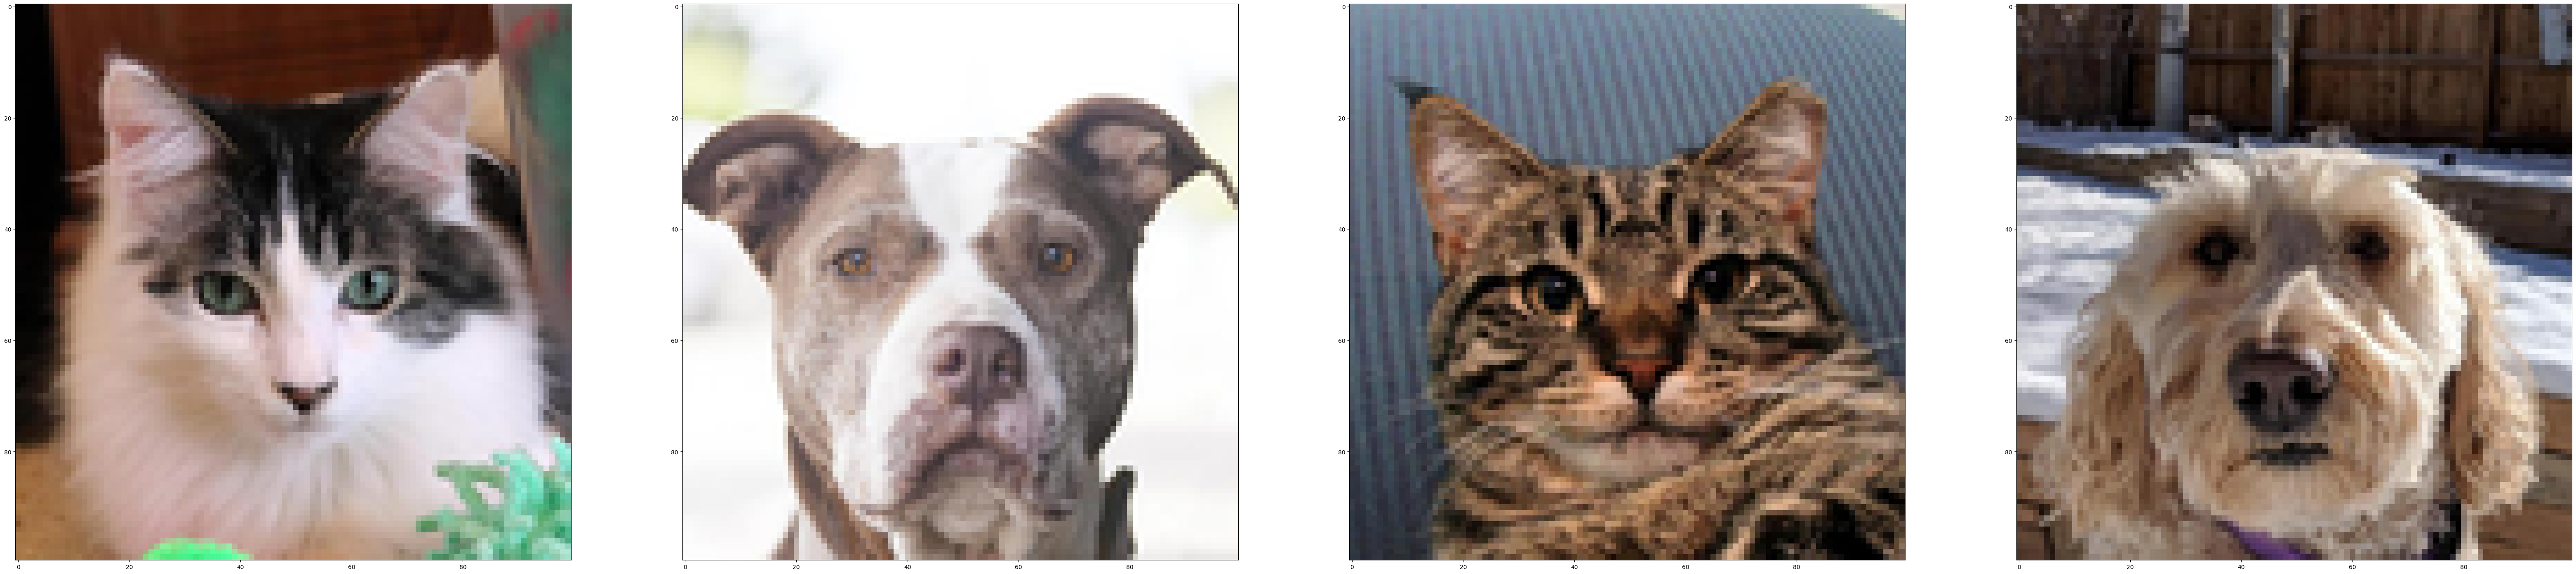

35363/35363 [==============================] - 0s 0us/step


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


1/1 [==============================] - 0s 20ms/step


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


1/1 [==============================] - 0s 19ms/step


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


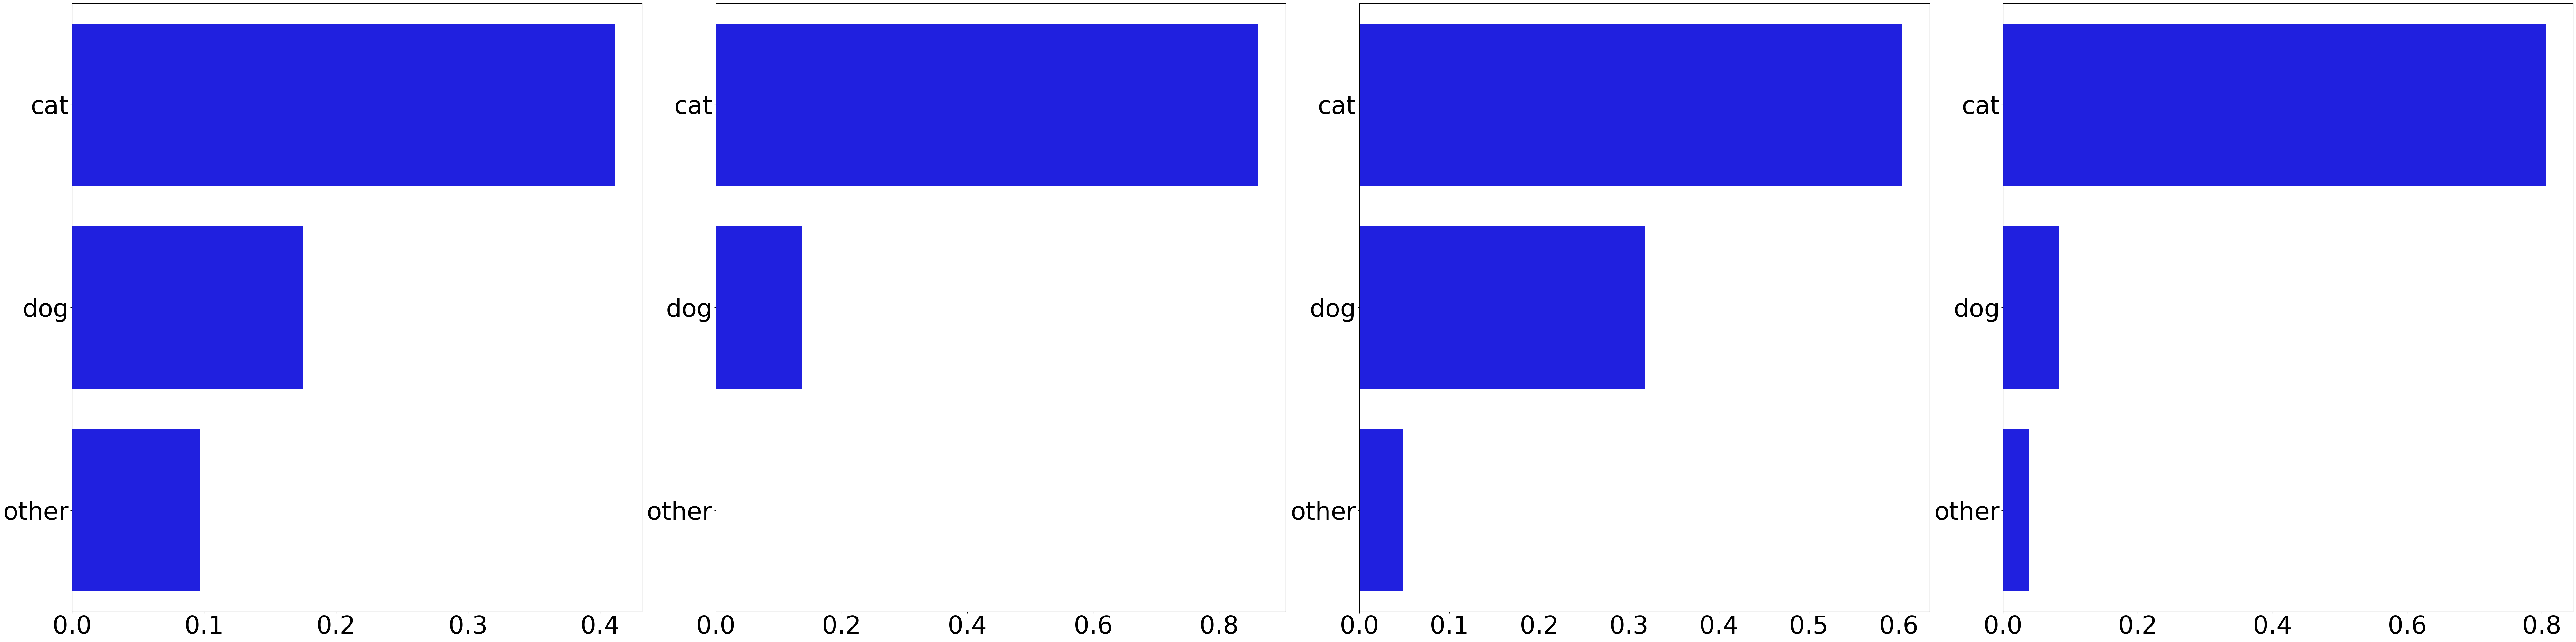

In [18]:
vgg16_model = VGG16(weights='imagenet') #loading VGG16 model with pre-trained weights from the ImageNet dataset
_get_predictions(vgg16_model) #function to get prdictions from the VGG16 model

In [19]:
#model.compile(optimizer=Adam(learning_rate=0.001), #using the Adam optimizer with learning rate of 0.001
 #             loss='categorical_crossentropy', #specifing loss function to use for optimization
  #            metrics=['accuracy']) #specifing metric(s) to evaluate the model's performance
#history = model.fit( #function that trains the model for a fixed number of epochs
  #  training_set, #dataset used for training model
   # epochs=10, #number of iterations over the dataset
    #validation_data=test_set) #validation the performance of the trained model

In [20]:
#acc = history.history['accuracy'] #extract the accuracy history from the model's training history
#val_acc = history.history['val_accuracy'] #extract the validation accuracy history from the model's training history
#loss = history.history['loss'] #extract the loss history from the model's training history
#val_loss = history.history['val_loss'] #extract the validation loss history from the model's training history
#epochs_range = range(len(acc)) #represents number of epochs for which the model was trained
#plt.figure(figsize=(15, 15)) #creating new figure for plotting
#plt.subplot(2, 2, 1) #adding subplot for training & validation accuracy

##plot for training accuracy
#plt.plot(epochs_range, 
       #  acc, label='Training Accuracy', 
        # color='#005f87')
        
##plot for validation accuracy
#plt.plot(epochs_range, 
         #val_acc, 
         #label='Validation Accuracy', 
         #color='#af0000')
#plt.legend(loc='upper right') #adding legend at the upper right of the plot
#plt.title('Training and Validation Accuracy') #adding title to the plot
#plt.subplot(2, 2, 2) #adding subplot for training & validation loss

##plot for training loss
#plt.plot(epochs_range, 
        # loss, 
        # label='Training Loss', 
        # color='#005f87')
        
##plot for validation loss
#plt.plot(epochs_range, 
       #  val_loss, 
        # label='Validation Loss', 
        # color='#af0000')
#plt.legend(loc='upper right') #adding legend at the upper right of the plot
#plt.title('Training and Validation Loss') #adding title to the plot
#plt.show() #displaying the plots for accuracy and loss